# Anomalie Detection on TEP Dataset

This Notebook is part of the Bachelors Thesis "Anomalieerkennung an industriellen Anlagen mit Long Short Term Memory Auto Encoder Netzwerken"

In [1]:
import pandas as pd
import numpy as np
import datetime
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pyreadr as pr
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow import keras

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.losses import Huber
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, MultiHeadAttention, LayerNormalization, Bidirectional
from keras.models import Model
from keras.regularizers import l2

from timeserieslibrary.Preprocessing_TEP import TimeSeriesPreprocessingPipeline, to_multiple_timeseries_reverse

sns.set(color_codes=True)

print("is GPU:",tf.config.list_physical_devices('GPU'))
print("is cuda:",tf.test.is_built_with_cuda())
print(tf.__version__)



is GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
is cuda: True
2.10.0


# Load the Data

In [2]:
###Load the Data###
#Trainings Data
data_normal_train = pr.read_r('TEP_Dataset/TEP_FaultFree_Training.RData')
data_normal_train = pd.DataFrame(data_normal_train['fault_free_training'])

#Split Training Data in Training and Validation Data
data_normal_train, data_normal_valid = train_test_split(data_normal_train, test_size=0.3)


#Normal Test Data
data_test_normal = pr.read_r('TEP_Dataset/TEP_FaultFree_Testing.RData')
data_test_normal = pd.DataFrame(data_test_normal['fault_free_testing'])

#Anomalie Data
#data_test_faulty_train = pr.read_r('TEP_Dataset/TEP_Faulty_Training.RData')
#data_test_faulty_train = pd.DataFrame(data_test_faulty_train['faulty_training'])
data_test_faulty_test = pr.read_r('TEP_Dataset/TEP_Faulty_Testing.RData')
data_test_faulty_test = pd.DataFrame(data_test_faulty_test['faulty_testing'])


# Aussortieren der schlechten Daten


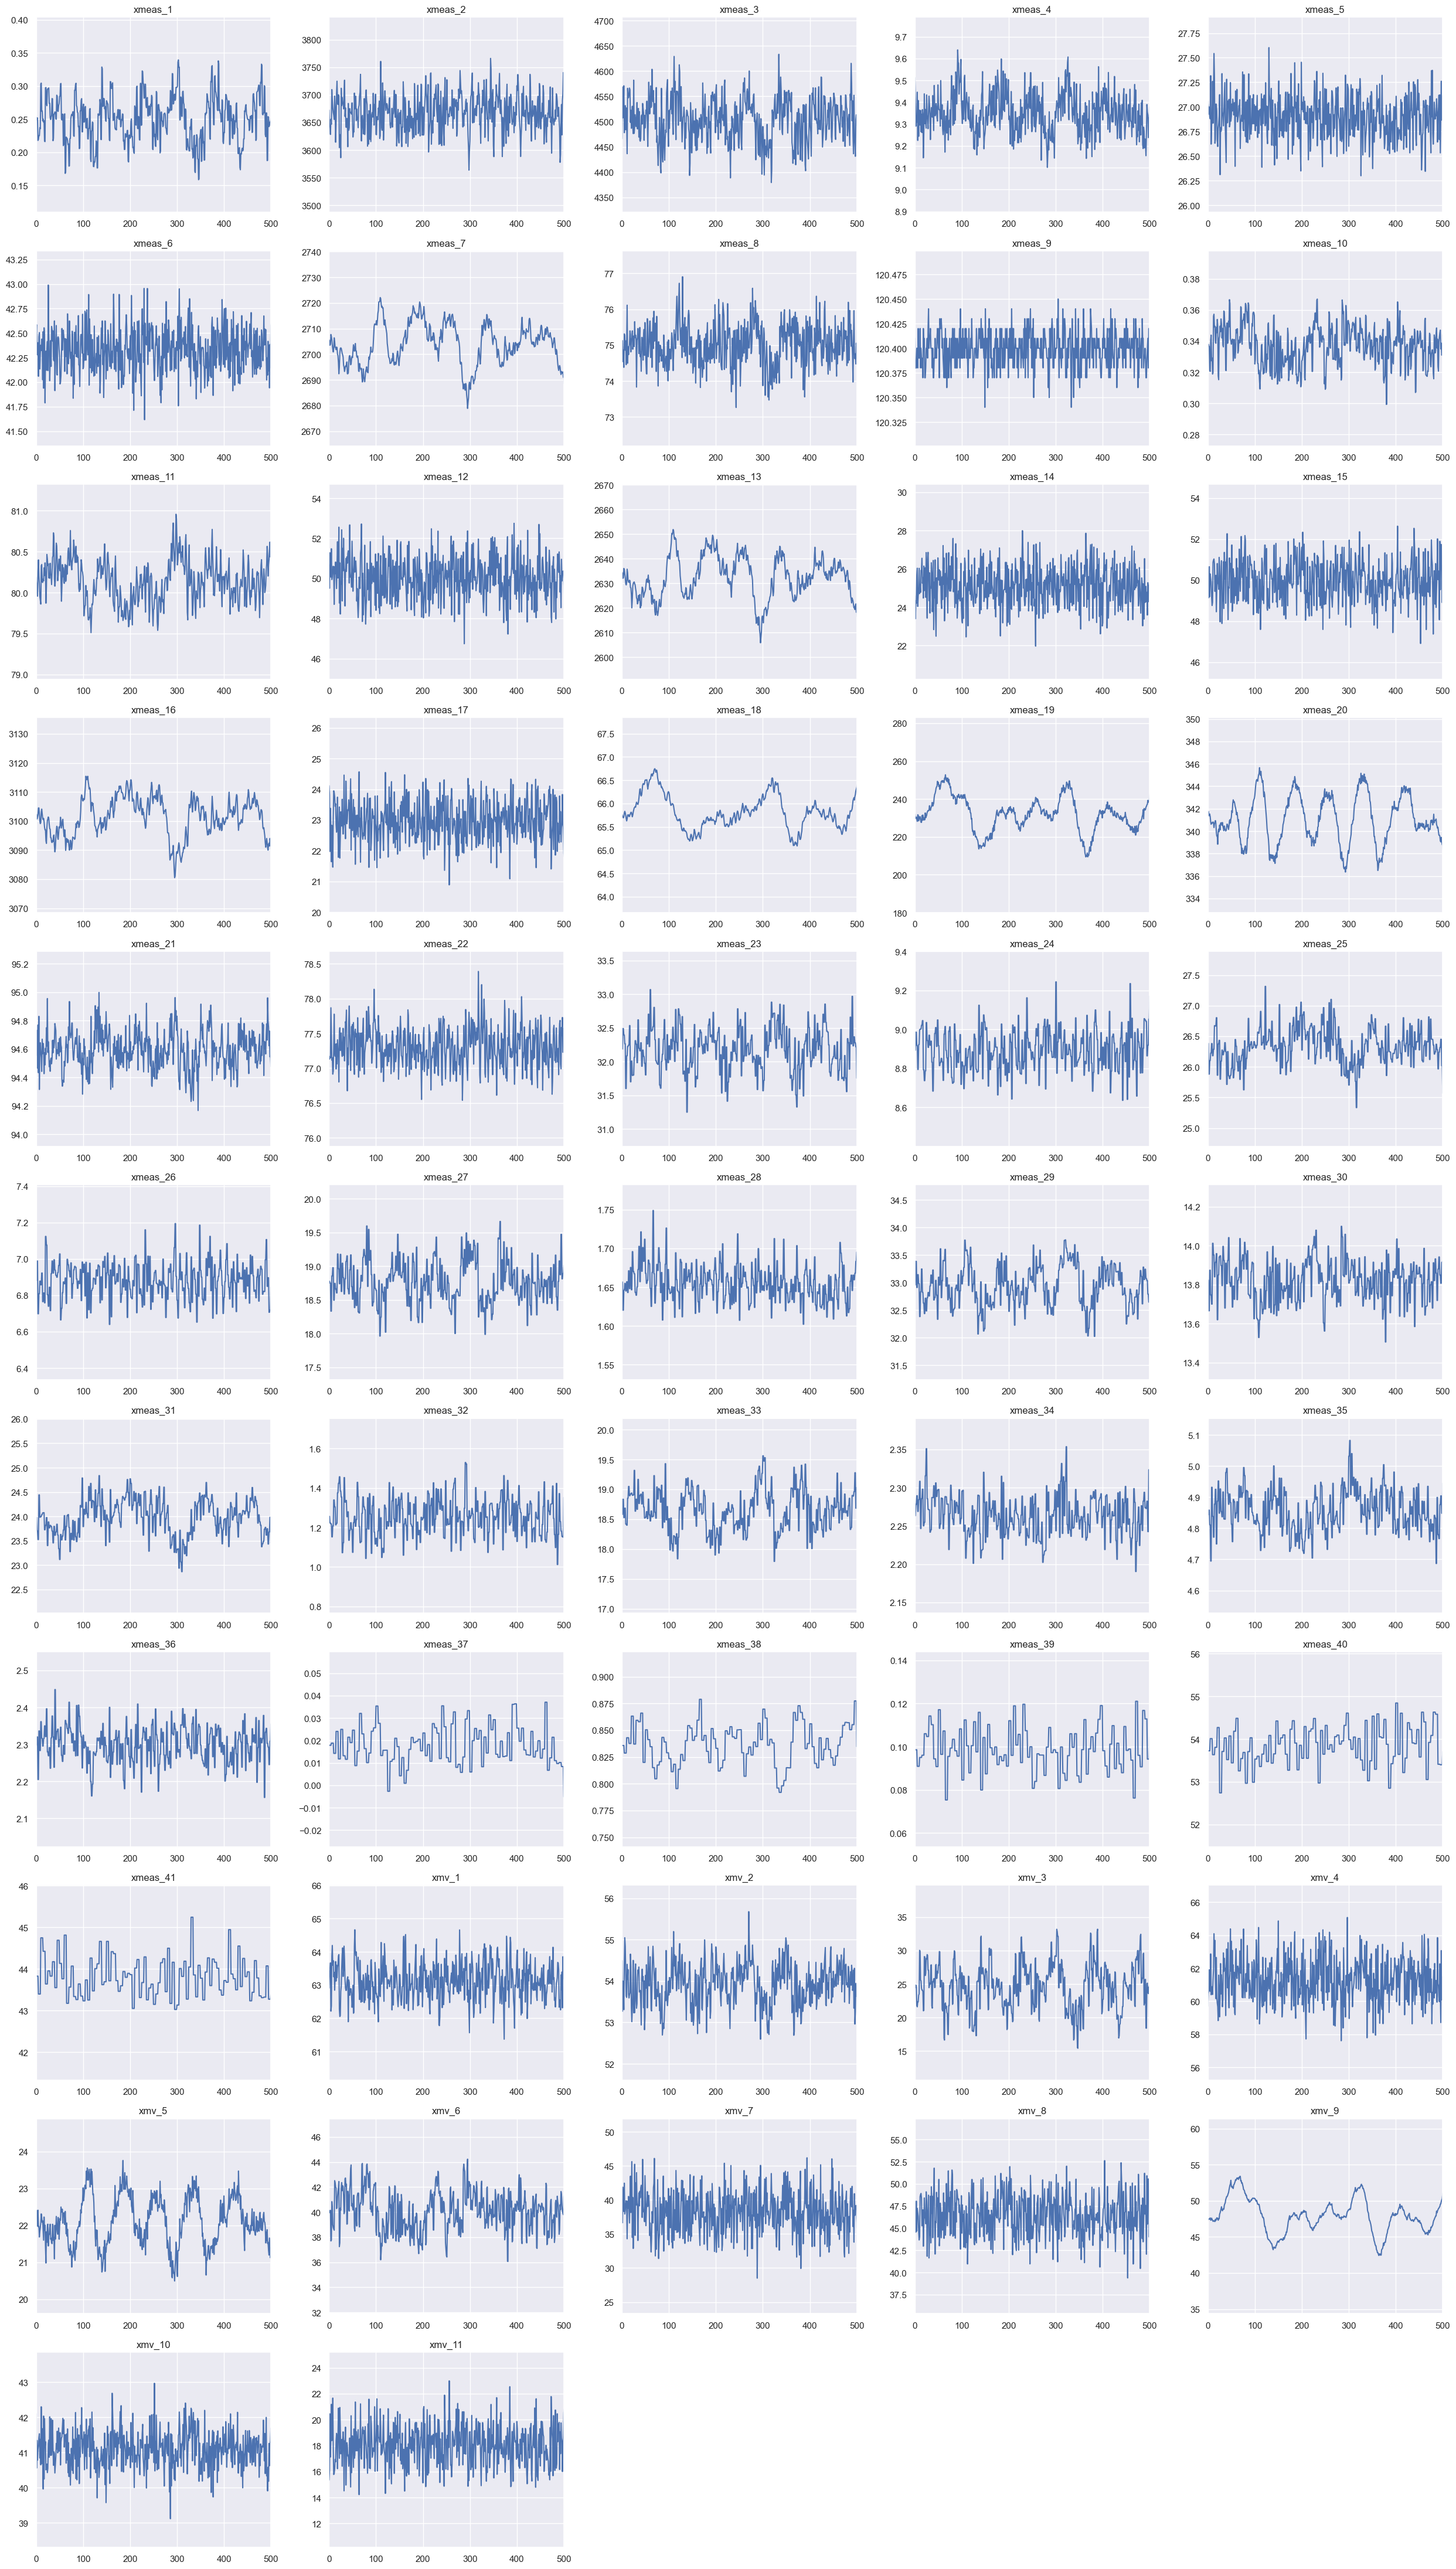

In [3]:
# Überspringe die ersten 2 Spalten
start_col = 3
num_plots = data_test_normal.shape[1] - start_col  # Anzahl der anzuzeigenden Plots

# Maximale Anzahl von Plots pro Zeile
cols = min(5, num_plots)
rows = math.ceil(num_plots / cols)  # Dynamisch berechnete Anzahl der Zeilen

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))  # Grid erstellen

axes = axes.flatten()  # In 1D-Array umwandeln, damit `axes[i]` funktioniert

# Die Spaltennamen aus dem DataFrame holen
variable_names = data_test_normal.columns[start_col:]  # Ab Spalte 2

# Plots erstellen
for i, col_name in enumerate(variable_names):
    axes[i].set_xlim([0, 500])
    axes[i].plot(data_test_normal.iloc[:, start_col + i])  # Richtige Spalte plotten
    axes[i].set_title(col_name)  # Variablennamen als Titel setzen

# Falls mehr Subplots vorhanden sind als benötigte Variablen, entferne leere Plots
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


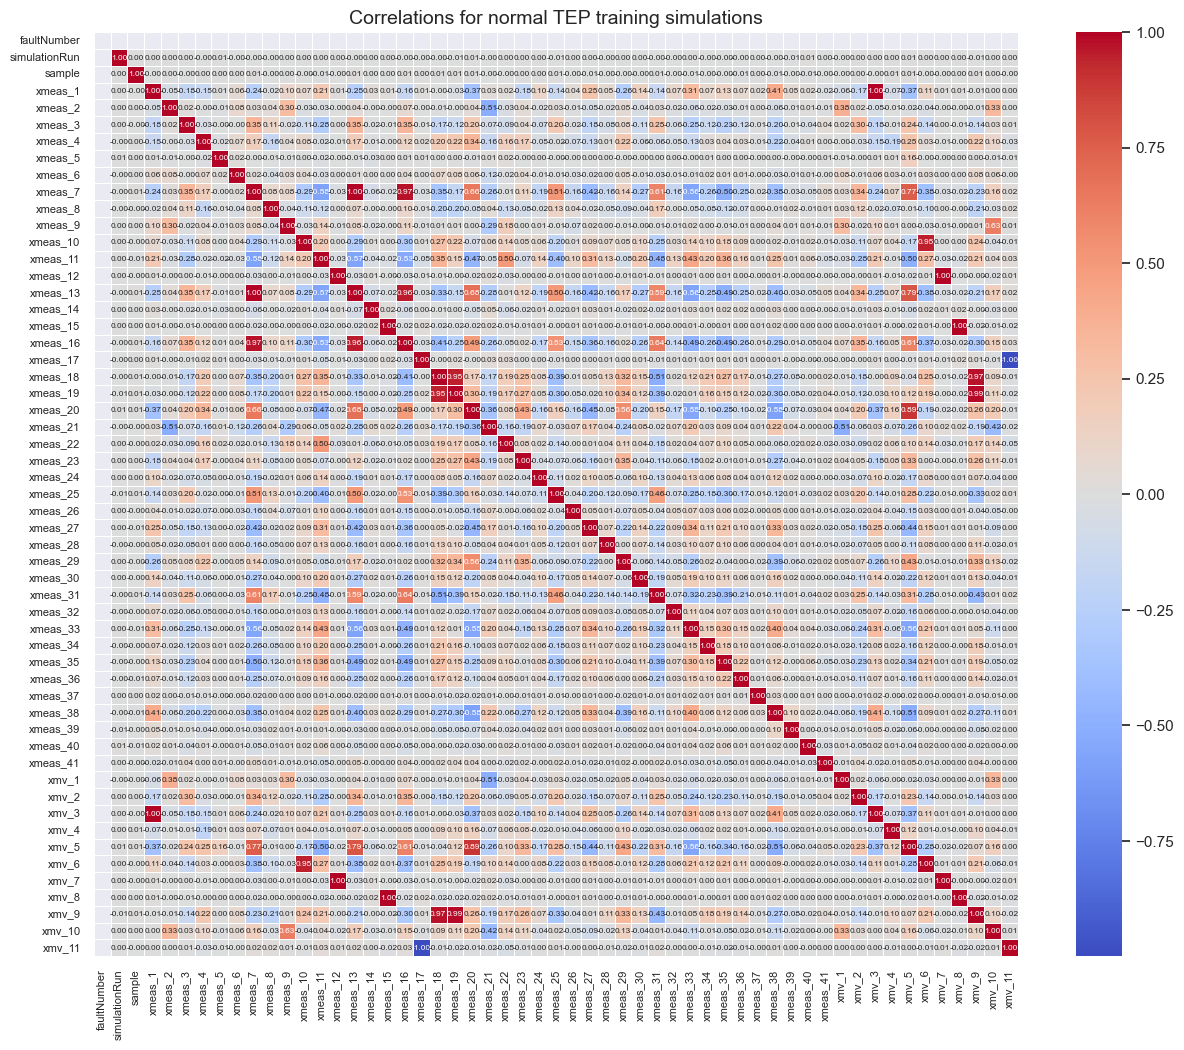

In [4]:
# Korrelationsmatrix
corr_matrix = data_normal_train.corr()
plt.figure(figsize=(15, 12))

sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f",
            cmap="coolwarm",
            center=0,
            linewidths=0.5, 
            square=True,
            annot_kws={"size": 6})  # Kleinere Schriftgröße für Werte

plt.xticks(rotation=90, fontsize=8)  # X-Achse drehen für bessere Lesbarkeit
plt.yticks(fontsize=8)  # Y-Achse kleiner machen
plt.title("Correlations for normal TEP training simulations", fontsize=14)
plt.show()

### Schlechte Daten aussortieren

In [5]:
var_to_remove = ['xmeas_9', 'xmeas_18', 'xmeas_7', 'xmeas_13', 'xmv_11', 'xmv_9', 'xmv_7', 'xmv_6', 'xmv_5', 'xmv_3']

data_normal_train.drop(columns=var_to_remove, inplace=True)
data_normal_valid.drop(columns=var_to_remove, inplace=True)
data_test_normal.drop(columns=var_to_remove, inplace=True)
#data_test_faulty_train.drop(columns=var_to_remove, inplace=True)
data_test_faulty_test.drop(columns=var_to_remove, inplace=True)

In [6]:
#Cobine all test data
all_test_data = [data_test_normal, data_test_faulty_test]
all_test_data_names=["Normal", "Anomalie_test"]

# Aufteilen der Daten

In [7]:
print("Trainings Data Shape:", data_normal_train.shape)
print("Validation Data Shape:", data_normal_valid.shape)

for variable, testdata in enumerate(all_test_data):
    print(all_test_data_names[variable], "Test Data Shape:", testdata.shape)

Trainings Data Shape: (175000, 45)
Validation Data Shape: (75000, 45)
Normal Test Data Shape: (480000, 45)
Anomalie_test Test Data Shape: (9600000, 45)


In [8]:
input_variablen = []
for variable in range(3,45):
    input_variablen.append(variable)


ground_truth_variable= [5, 6, 10, 18]
name_list = list(data_normal_valid.columns.values.tolist())

name_dict = {}
for variable in range(len(name_list)):
    name_dict[variable]=name_list[variable]

In [9]:
variablen_to_mask_index_list=[]
for variable in ground_truth_variable:
    variablen_to_mask_index_list += [np.where(np.array(input_variablen) == variable)]

In [10]:
ground_truth_name_list=[name_list[i] for i in ground_truth_variable]
ground_truth_variable_names = [name_dict[j] for j in ground_truth_variable]
print(ground_truth_variable_names)

['xmeas_3', 'xmeas_4', 'xmeas_10', 'xmeas_20']


# Preprocess Data

In [11]:
###Preprocessing Data###
input_window=500
sliding_window_step=500
mask_input_data=False
scale_data=False
#data_multiplicator_for_masking = 4
#data_mask_lenght=0.5

In [12]:
#Window_lenght_in_ms
original_sample_time=6
window_time=original_sample_time*input_window
print("window time", np.round(window_time/1000, 2))

window time 3.0


In [13]:
#ts_processing = pp.TimeSeriesPreprocessingPipeline(  JSON_config_file="preprocessing_config.json")

ts_processing = TimeSeriesPreprocessingPipeline(split_time_series_into_window_of_len=input_window,
                                             input_variable_index_list=input_variablen,
                                             sliding_window_step=sliding_window_step,
                                             scale_data=scale_data,
                                             ground_truth_variable_index_list=ground_truth_variable,
                                             mask_input_data=mask_input_data
                                             )

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(data_normal_train)
x_valid_scaled = scaler.transform(data_normal_valid)

x_train, y_train = ts_processing(x_train_scaled, stride_of_window=100, is_test_data=False)
x_valid, y_valid = ts_processing(x_valid_scaled, stride_of_window=100, is_test_data=True)

ts_processing.save_config_as_JSON()


Input data shape: (175000, 45)
Shape of x data (1746, 500, 43)
Shape of y data (1746, 500, 4)

Input data shape: (75000, 45)
Shape of x data (746, 500, 43)
Shape of y data (746, 500, 4)


# Skalierung der Daten

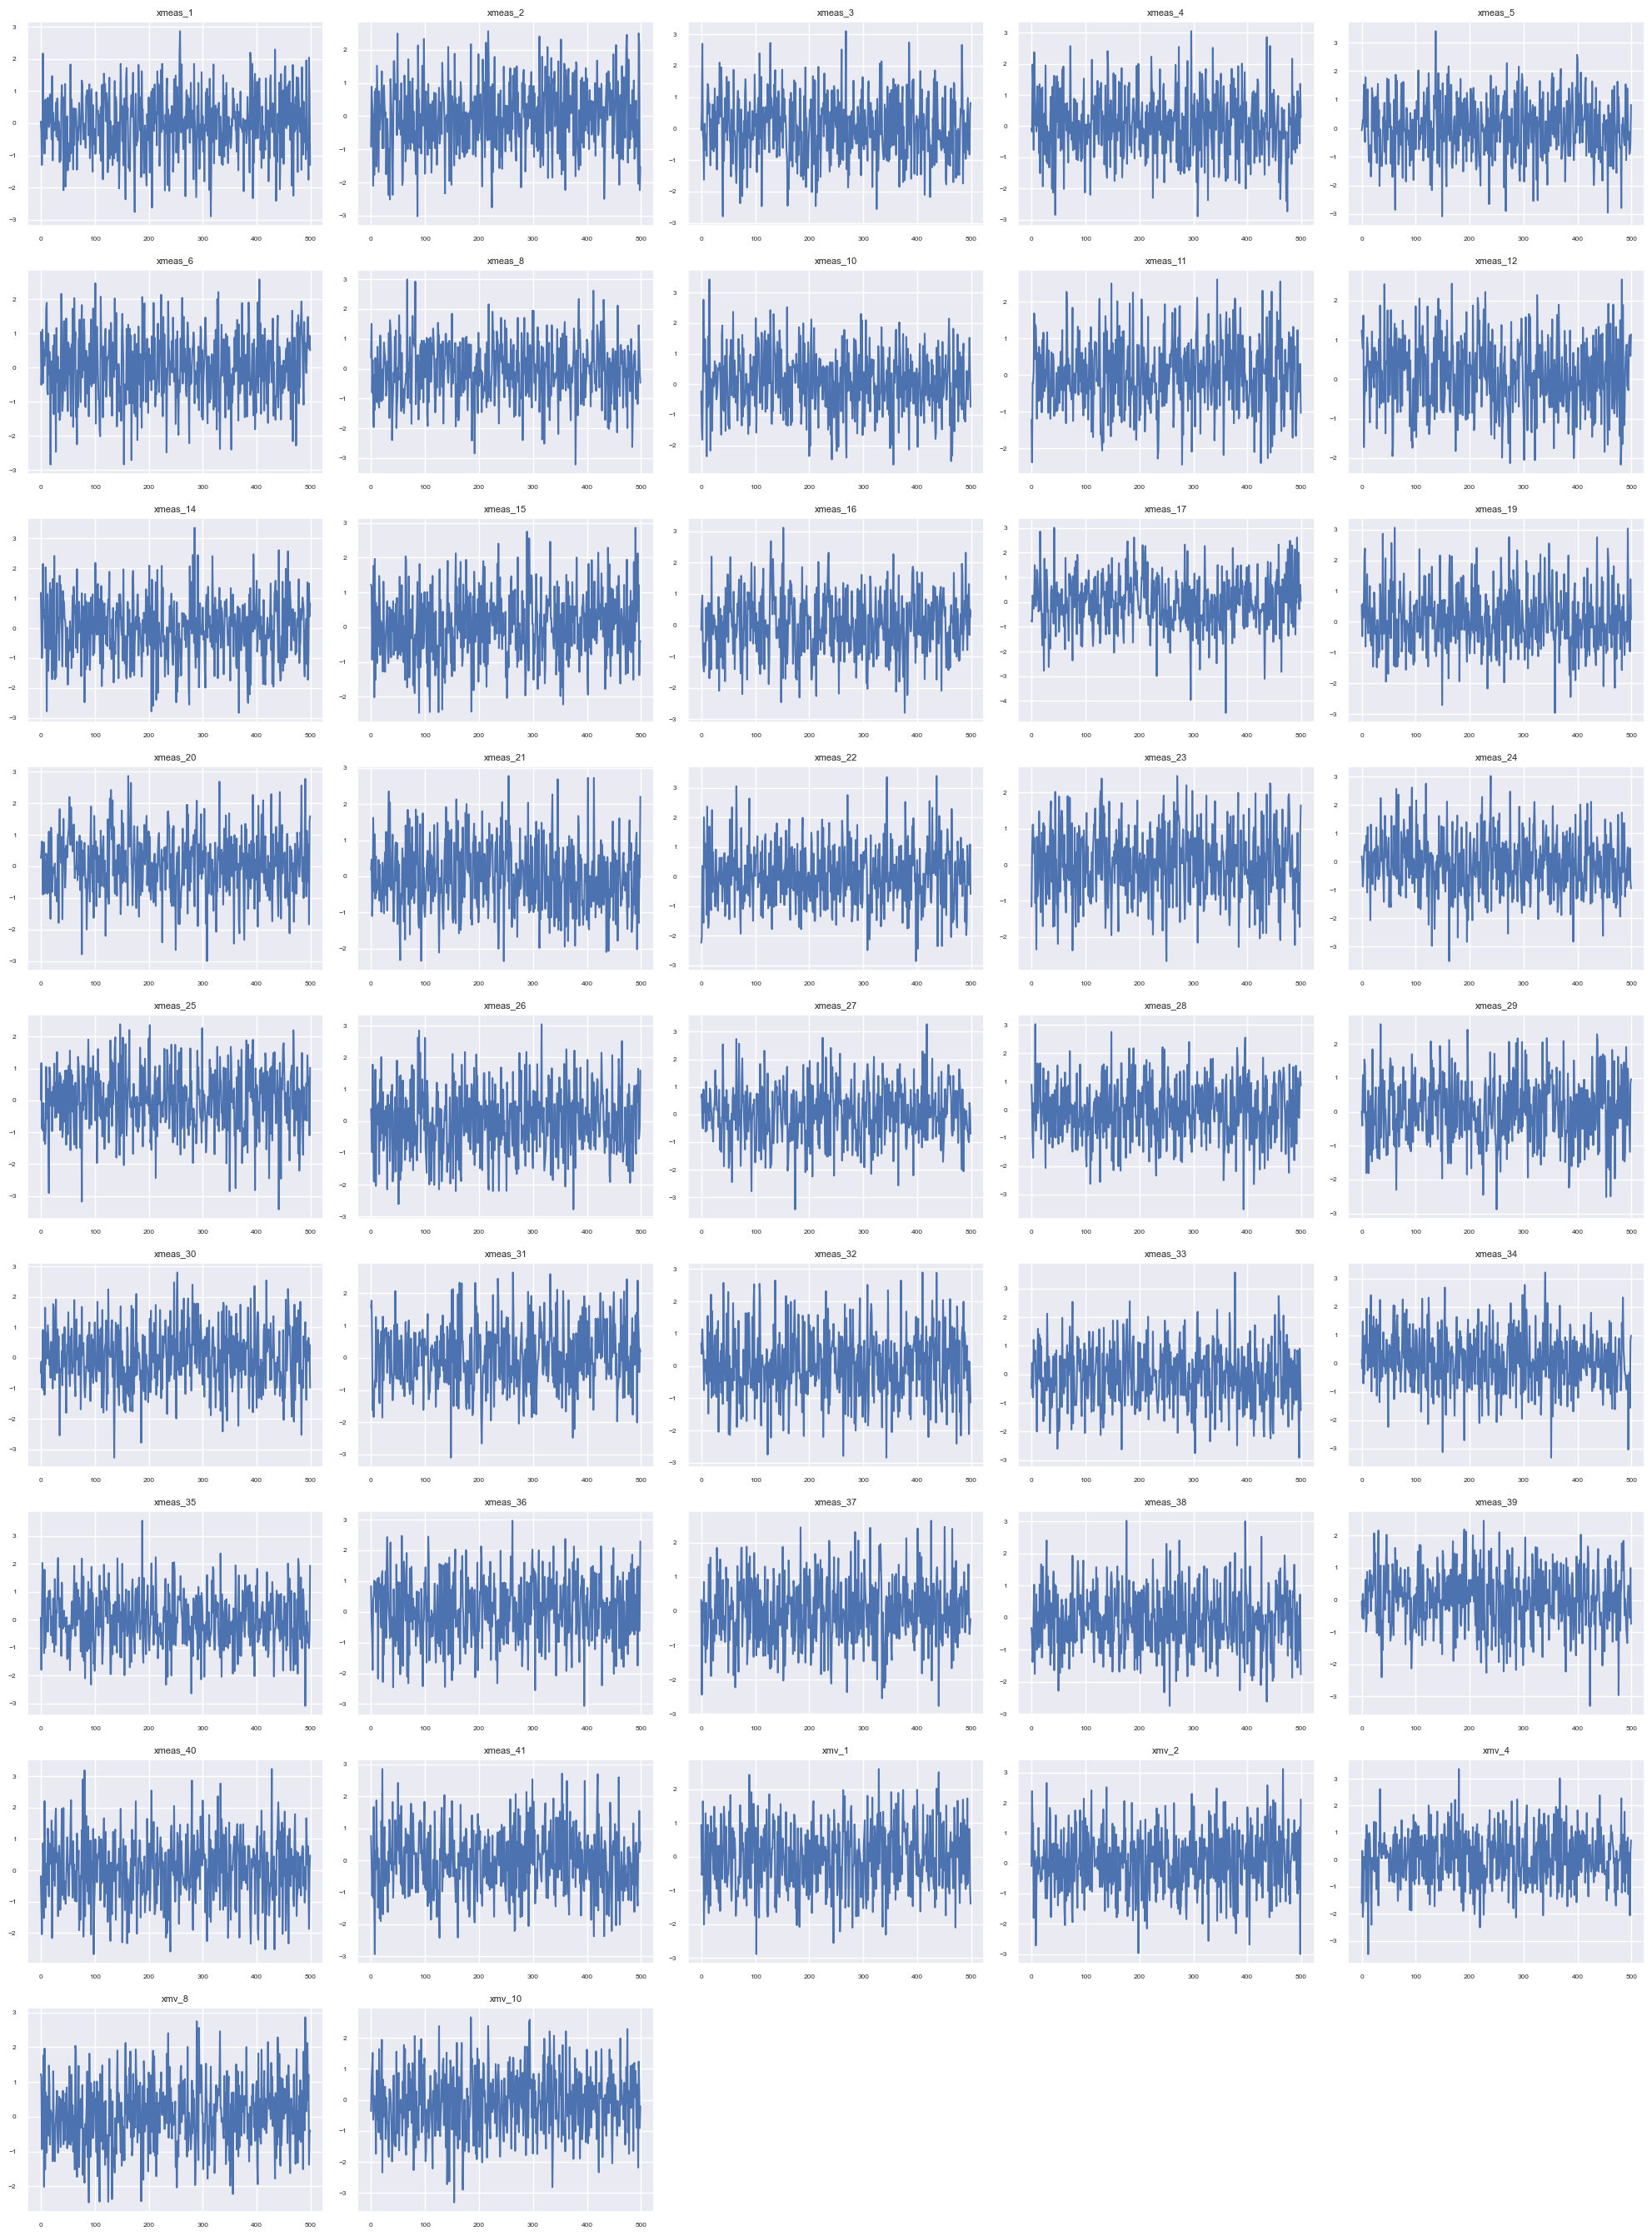

In [14]:
num_plots = x_train_scaled.shape[-1] - 3  # Anzahl der Variablen
cols = min(5, num_plots)  # Maximal 5 Plots pro Zeile
rows = math.ceil(num_plots / cols)  # Berechnet die benötigte Anzahl an Zeilen

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))  # Kleinere Plots

axes = axes.flatten()  # Falls es eine 2D-Array von Subplots gibt, in 1D umwandeln

for i, variable in enumerate(range(num_plots)):
    var_name = name_list[input_variablen[variable]]
    
    axes[i].plot(x_train[1, :, variable])  # Linien-Plot wie vorher
    axes[i].set_title(var_name, fontsize=8)  # Kleinere Schriftgröße
    axes[i].tick_params(axis='both', labelsize=6)  # Kleinere Achsenbeschriftungen

# Leere Plots entfernen, falls es mehr Subplots als Variablen gibt
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()  # Sorgt für bessere Anordnung der Plots
plt.show()


# Show preprocessed data

In [15]:
# Annahme: all_test_data enthält genau 3 Elemente
data_test_transformed_normal = scaler.transform(all_test_data[0])
#data_test_transformed_faulty_train = scaler.transform(all_test_data[1])
data_test_transformed_faulty_test = scaler.transform(all_test_data[1])

x1, y1 = ts_processing(data_test_transformed_normal, stride_of_window=100, is_test_data=True)
#x2, y2 = ts_processing(data_test_transformed_faulty_train, stride_of_window=100, is_test_data=True)
x3, y3 = ts_processing(data_test_transformed_faulty_test, stride_of_window=500, is_test_data=True) # Höhere Stride, da nicht ausreichend RAM für stride=100

test_data_preprocessed_x = [
    np.array(x1, dtype=np.float32),
    #np.array(x2, dtype=np.float32),
    np.array(x3, dtype=np.float32)
]

test_data_preprocessed_y = [
    np.array(y1, dtype=np.float32),
    #np.array(y2, dtype=np.float32),
    np.array(y3, dtype=np.float32)
]



Input data shape: (480000, 45)
Shape of x data (4796, 500, 43)
Shape of y data (4796, 500, 4)

Input data shape: (9600000, 45)
Shape of x data (19200, 500, 43)
Shape of y data (19200, 500, 4)


Variable: xmeas_4


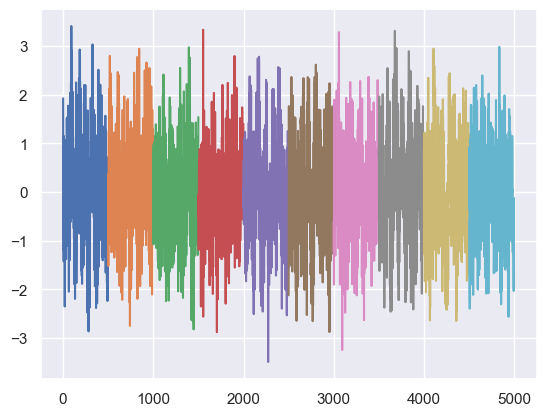

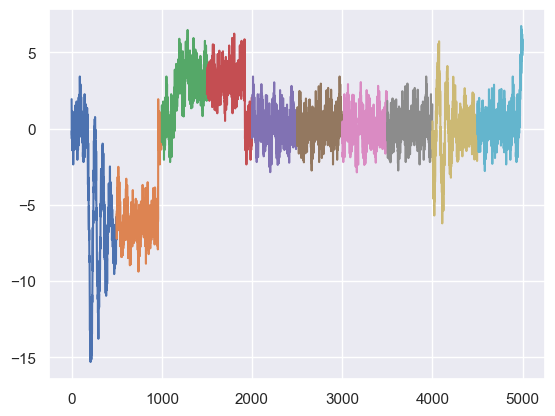

'for window in range(10):\n    x__=np.arange(window*input_window,(window+1)*input_window)\n    plt.plot(x__,test_data_preprocessed_y[2][window,:,variable])\nplt.show()'

In [16]:
### Show preprocessed Data ###
variable = 1

print("Variable:", name_list[ground_truth_variable[variable]])
for window in range(10):
    x__=np.arange(window*input_window,(window+1)*input_window)
    plt.plot(x__,test_data_preprocessed_y[0][window,:,variable])
plt.show()
for window in range(10):
    x__=np.arange(window*input_window,(window+1)*input_window)
    plt.plot(x__,test_data_preprocessed_y[1][window,:,variable])
plt.show()

'''for window in range(10):
    x__=np.arange(window*input_window,(window+1)*input_window)
    plt.plot(x__,test_data_preprocessed_y[2][window,:,variable])
plt.show()'''

# Create Model 

In [76]:
def autoencoder_model(input_shape, output_dim):
    inputs = Input(shape=input_shape)

    # **Encoder (LSTM-Schichten)**
    encoded = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    encoded = LayerNormalization()(encoded)
    encoded = Dropout(0.2)(encoded)
    
    encoded = Bidirectional(LSTM(32, return_sequences=True))(encoded)
    
    encoded = Bidirectional(LSTM(16, return_sequences=True))(encoded) 


    attention_output = MultiHeadAttention(num_heads=5, key_dim=32, dropout=0.2)(query=encoded, key=encoded, value=inputs)
    attention_output = LayerNormalization()(attention_output)
    
    # Latenter Raum (Bottleneck)
    latent = Dense(16, activation="linear", name="latent_space")(attention_output)

    # **Decoder (LSTM-Schichten)**
    decoded = Bidirectional(LSTM(16, return_sequences=True))(latent)
    decoded = LayerNormalization()(decoded)
    decoded = Dropout(0.2)(decoded)
    
    decoded = Bidirectional(LSTM(32, return_sequences=True))(decoded)

    decoded = Bidirectional(LSTM(64, return_sequences=True))(decoded)

    outputs = TimeDistributed(Dense(y_train.shape[-1]))(decoded)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [77]:
batch_size = 64

#Learning rate schedule
#steps_per_epoch = (len(x_train) // batch_size)
#learning_rate = lrs.CosineDecayWithWarmup(steps_per_epoch*4,1e-3,steps_per_epoch*45)
#optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98) 

initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate, decay_steps=8000, alpha=0.3)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

#lr_scheduler = CosineDecay(initial_learning_rate=initial_learning_rate, decay_steps=decay_steps)
#optimizer = Adam(learning_rate=learning_rate)  # Changed optimizer to Adam

# Modell erstellen und kompilieren
model = autoencoder_model((x_train.shape[1], x_train.shape[2]), y_train.shape[-1])
model.compile(optimizer=optimizer, loss=Huber(delta=1.0))
model.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 500, 43)]    0           []                               
                                                                                                  
 bidirectional_42 (Bidirectiona  (None, 500, 128)    55296       ['input_8[0][0]']                
 l)                                                                                               
                                                                                                  
 layer_normalization_21 (LayerN  (None, 500, 128)    256         ['bidirectional_42[0][0]']       
 ormalization)                                                                                    
                                                                                            

In [78]:
# fit the model to the data
nb_epochs = 150

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


history = model.fit(x_train, y_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.3, callbacks=[early_stopping], verbose=2).history

Epoch 1/150
20/20 - 15s - loss: 0.4275 - val_loss: 0.4250 - 15s/epoch - 751ms/step
Epoch 2/150
20/20 - 5s - loss: 0.4239 - val_loss: 0.4242 - 5s/epoch - 270ms/step
Epoch 3/150
20/20 - 5s - loss: 0.4216 - val_loss: 0.4163 - 5s/epoch - 271ms/step
Epoch 4/150
20/20 - 5s - loss: 0.4059 - val_loss: 0.3837 - 5s/epoch - 268ms/step
Epoch 5/150
20/20 - 5s - loss: 0.3551 - val_loss: 0.3088 - 5s/epoch - 256ms/step
Epoch 6/150
20/20 - 5s - loss: 0.3134 - val_loss: 0.2966 - 5s/epoch - 254ms/step
Epoch 7/150
20/20 - 5s - loss: 0.3035 - val_loss: 0.2939 - 5s/epoch - 255ms/step
Epoch 8/150
20/20 - 5s - loss: 0.2998 - val_loss: 0.2926 - 5s/epoch - 255ms/step
Epoch 9/150
20/20 - 5s - loss: 0.2980 - val_loss: 0.2919 - 5s/epoch - 253ms/step
Epoch 10/150
20/20 - 5s - loss: 0.2969 - val_loss: 0.2916 - 5s/epoch - 256ms/step
Epoch 11/150
20/20 - 5s - loss: 0.2962 - val_loss: 0.2929 - 5s/epoch - 255ms/step
Epoch 12/150
20/20 - 5s - loss: 0.2956 - val_loss: 0.2928 - 5s/epoch - 255ms/step
Epoch 13/150
20/20 - 5s

# Evaluation

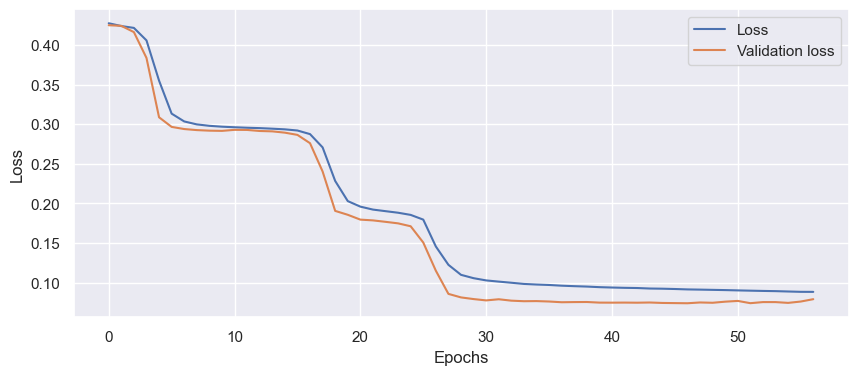

In [79]:
plt.plot(history['loss'], label='Loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [80]:
# Reconstruction Error
for variable in range(len(test_data_preprocessed_x)):
    print(all_test_data_names[variable])
    model.evaluate(test_data_preprocessed_x[variable], test_data_preprocessed_y[variable])


Normal
150/150 [==============================] - 17s 110ms/step - loss: 0.0777
Anomalie_test
600/600 [==============================] - 65s 109ms/step - loss: 1.8173


# Reconstruction of normal test data

150/150 [==============================] - 19s 110ms/step
normal test Data
(2398000, 4)
(2397936,)
Variable: xmeas_3


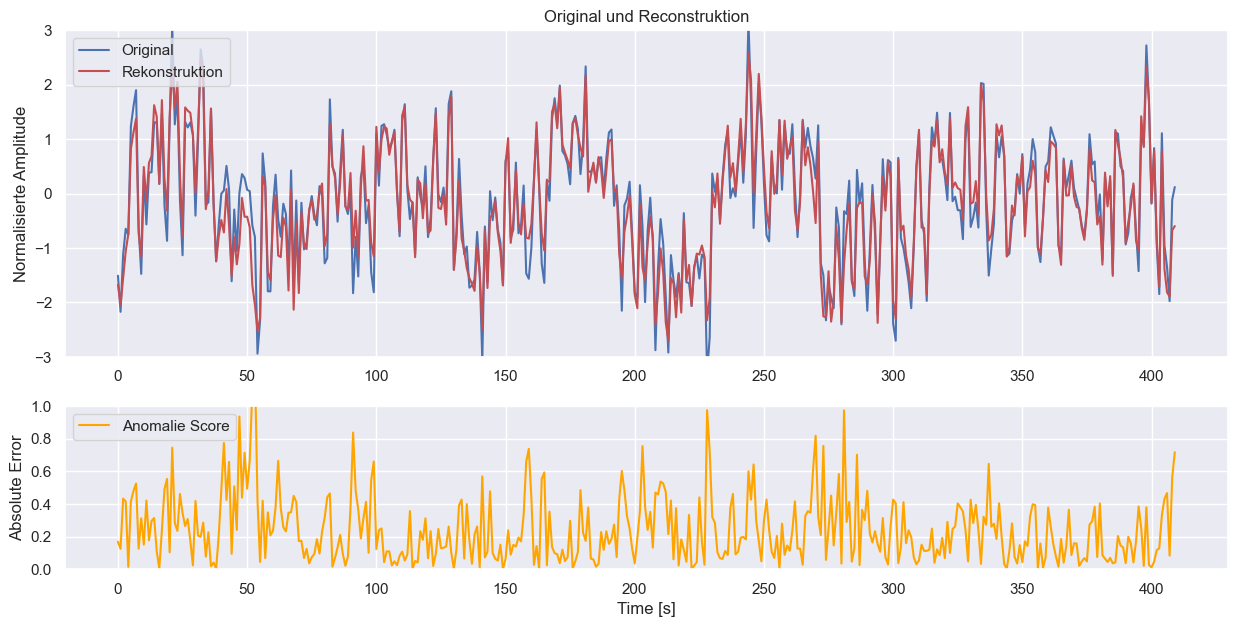

(2397936,)
Variable: xmeas_4


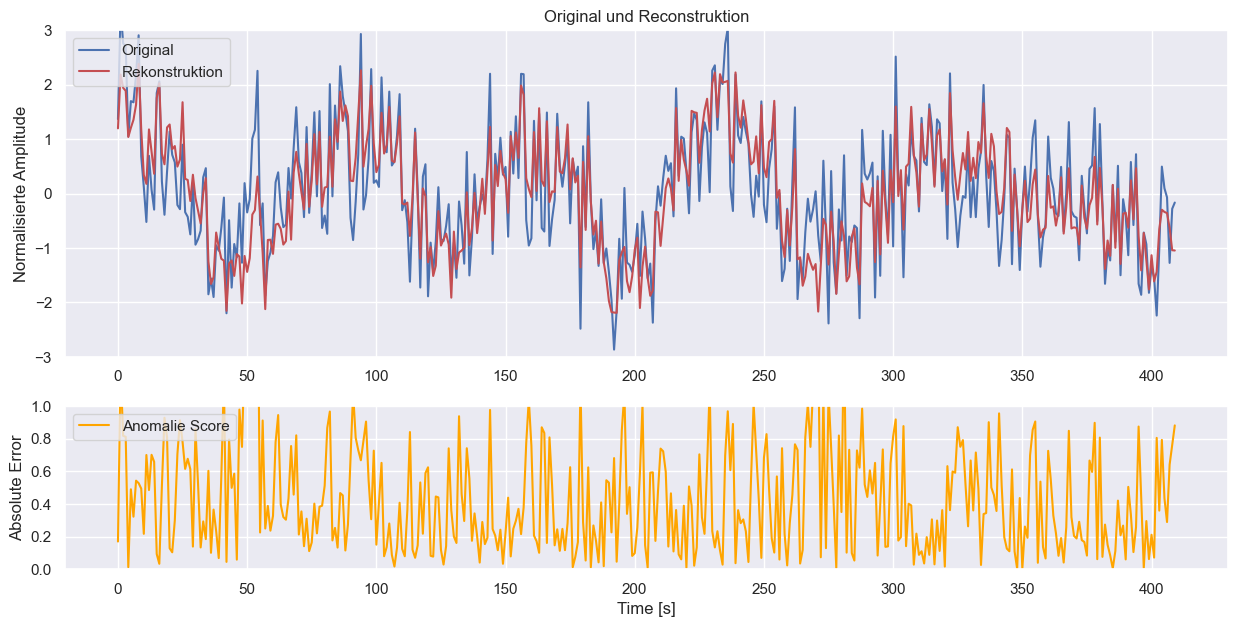

KeyboardInterrupt: 

In [81]:
prediction_normal = model.predict(test_data_preprocessed_x[0])
y_normal = test_data_preprocessed_y[0]
prediction_reconstruct=to_multiple_timeseries_reverse(prediction_normal)
y_reconstruct=to_multiple_timeseries_reverse(y_normal)



plt.rcParams['figure.figsize'] = [15, 7]
range_l = 90
range_u = 500

print("normal test Data")

print(prediction_reconstruct.shape)
for variable in range(prediction_reconstruct.shape[-1]):

    mean=[]
    window=64
    for l in range(len(y_reconstruct)-window):
        mean += [np.mean(np.abs(prediction_reconstruct[l:l+window,variable]-y_reconstruct[l:l+window,variable]))]

    mean = np.array(mean)
    print(mean.shape)


    fig, ax = plt.subplots(2, height_ratios=[2,1])
    print("Variable:", name_list[ground_truth_variable[variable]])
    ax[0].plot(y_reconstruct[range_l:range_u,variable], "b")
    ax[0].plot(prediction_reconstruct[range_l:range_u,variable], "r")
    ax[0].legend(["Original", "Rekonstruktion"], loc="upper left")
    ax[0].set_ylabel("Normalisierte Amplitude")
    ax[0].title.set_text('Original und Reconstruktion')
    #fig.title("Drehstich ohne Anomalie")
    ax[0].set_ylim(-3, 3)
    #time=np.arange(0,range_u-range_l,20)
    #ax[0].set_xticks(time, np.round((time*384)/1000, 1))


    ax[1].plot(np.abs(y_reconstruct[range_l:range_u,variable]-prediction_reconstruct[range_l:range_u,variable]), "orange")
    #ax[1].plot(mean[range_l:range_u], "r")
    
    ax[1].set_ylim(0, 1)
    #ax[1].set_xticks(time, np.round((time*384)/1000, 1))

    ax[1].set_ylabel("Absolute Error")
    ax[1].set_xlabel("Time [s]")
    ax[1].legend(["Anomalie Score"], loc="upper left")
    
    plt.show()


# Reconstruction of anomalie test data for each Anomalie

Plot one window of all variable of all anomalie classes

600/600 [==============================] - 62s 103ms/step
(9600000, 4)
(9600000, 4)
Anomlie: Anomalie_test
Variable: xmeas_3
(9599936,)


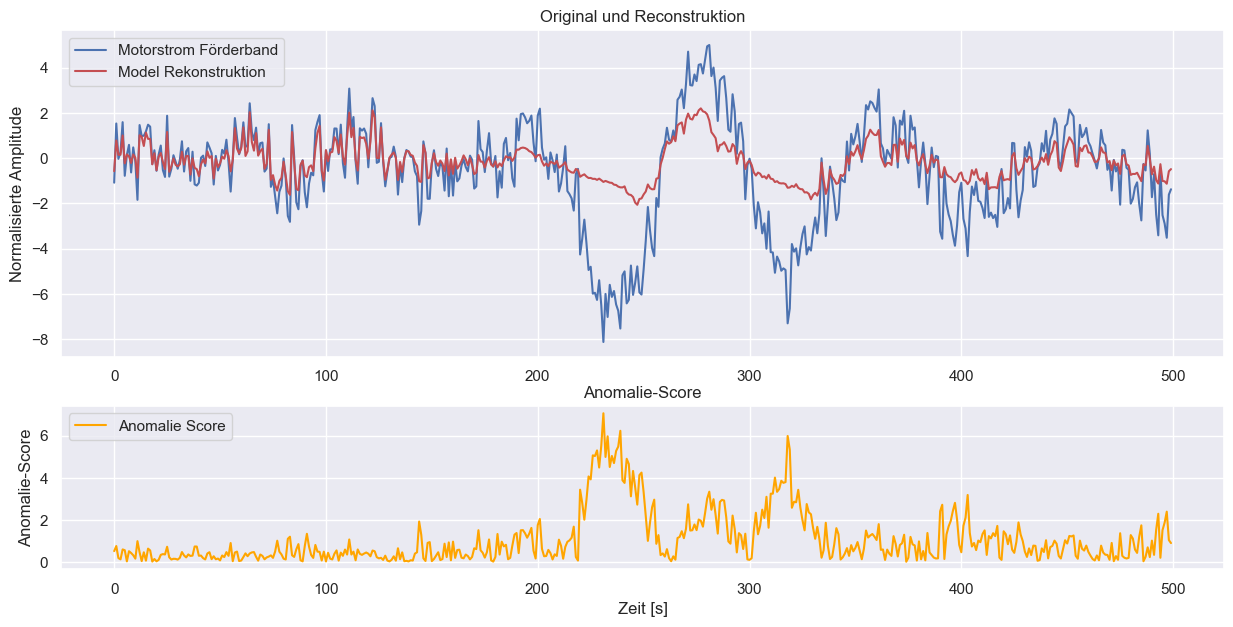

Variable: xmeas_4
(9599936,)


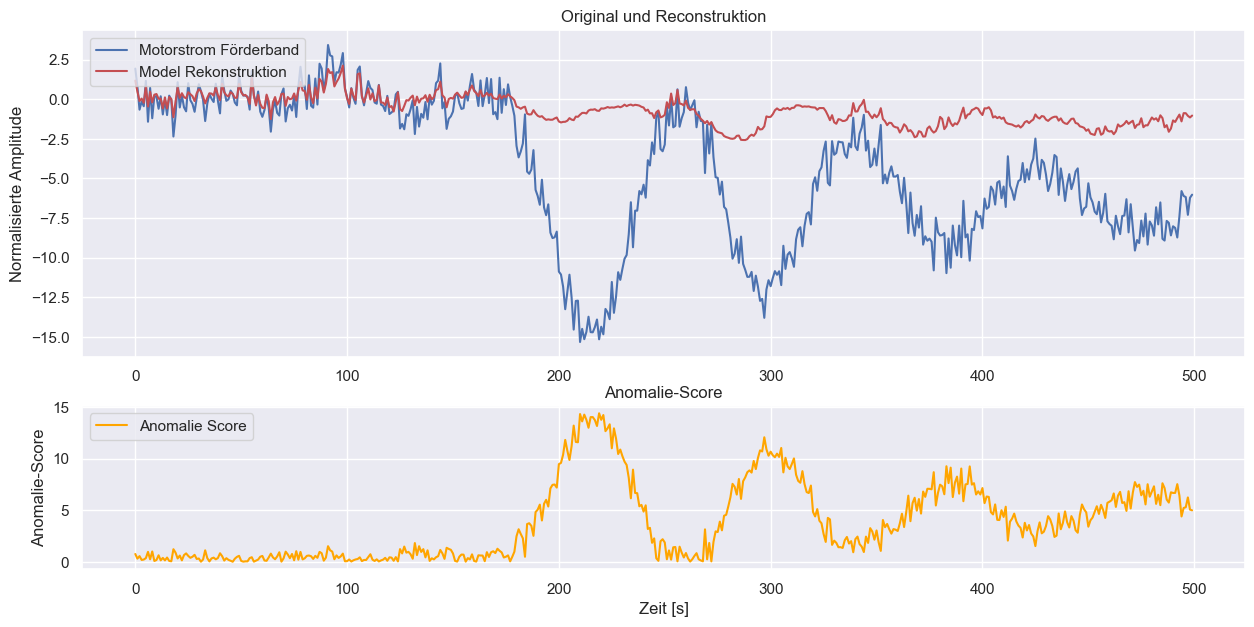

Variable: xmeas_10
(9599936,)


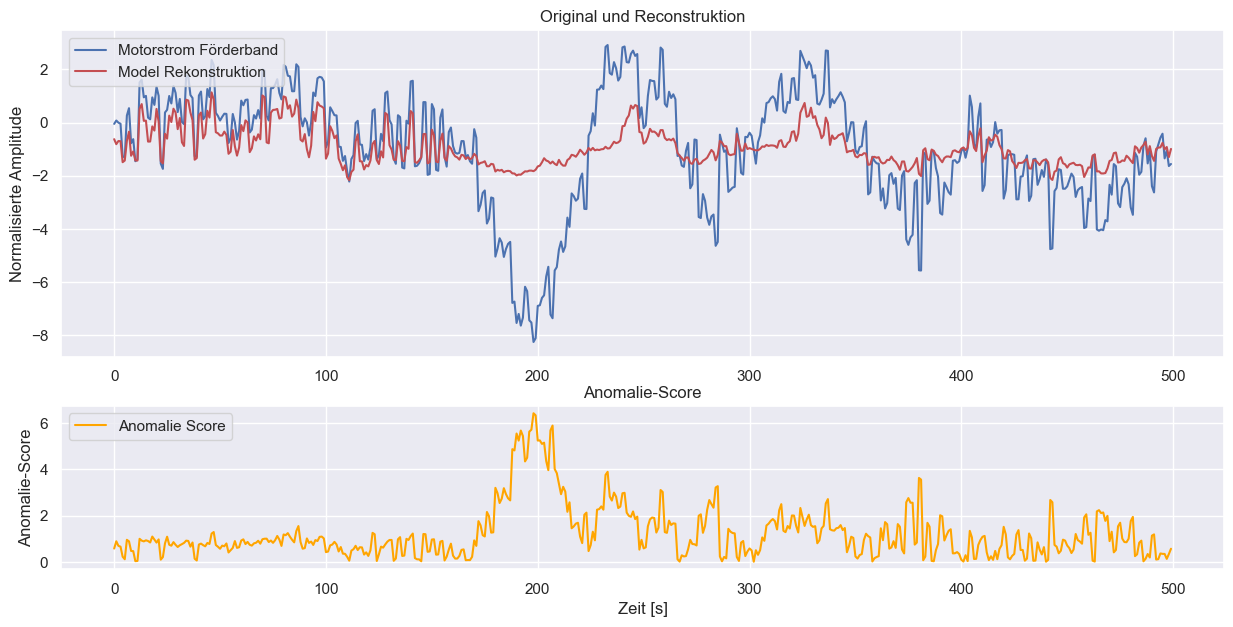

Variable: xmeas_20
(9599936,)


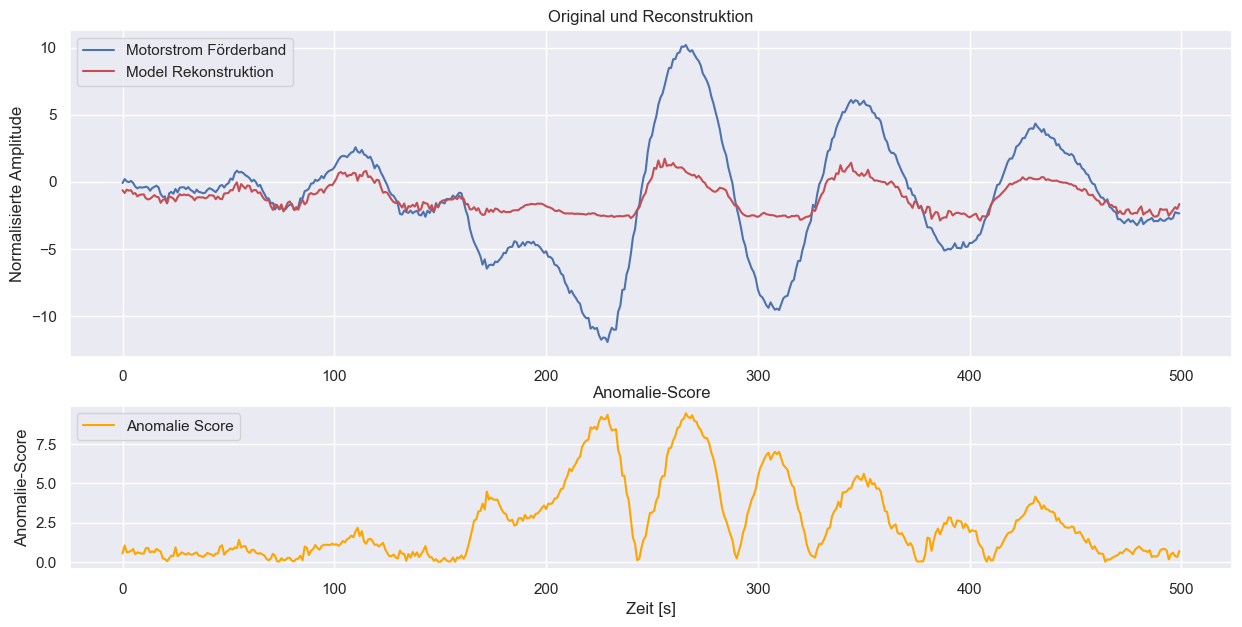

In [64]:
plt.rcParams['figure.figsize'] = [15, 7]
test_data_anaomlie_prediction=[]
test_data_anomalie_y=[]

range_l = 0
range_u = 500

for variable in range(1,len(test_data_preprocessed_x)):
    
    test_data_anaomlie_prediction += [model.predict(test_data_preprocessed_x[variable])]
    test_data_anomalie_y += [test_data_preprocessed_y[variable]]

    prediction_reconstruct=to_multiple_timeseries_reverse(test_data_anaomlie_prediction[variable-1])
    y_reconstruct=to_multiple_timeseries_reverse(test_data_anomalie_y[variable-1])
    print(y_reconstruct.shape)

    mean=[]

    print(prediction_reconstruct.shape)
    print("Anomlie:", all_test_data_names[variable])
    for j in range(prediction_reconstruct.shape[-1]):
        print("Variable:", name_list[ground_truth_variable[j]])


        mean=[]
        window=64
        for l in range(len(y_reconstruct)-window):
            mean += [np.mean(np.abs(prediction_reconstruct[l:l+window,j]-y_reconstruct[l:l+window,j]))]

        mean = np.array(mean)
        print(mean.shape)


        fig, ax = plt.subplots(2, height_ratios=[2,1])
   
        #ax[0].set_ylim(-3, 3)
        ax[0].plot(y_reconstruct[range_l:range_u,j], "b")
        ax[0].plot(prediction_reconstruct[range_l:range_u,j], "r")
        ax[0].title.set_text('Original und Reconstruktion')
        ax[0].legend(["Motorstrom Förderband", "Model Rekonstruktion"], loc="upper left")#[name_list[ground_truth_variable[i]], str(name_list[ground_truth_variable[i]]) + " Prediction"])
        plt.xlabel("Zeit [s]")
        ax[0].set_ylabel("Normalisierte Amplitude")       





        ax[1].plot(np.abs(y_reconstruct[range_l:range_u,j]-prediction_reconstruct[range_l:range_u,j]), "orange")
        ax[1].title.set_text('Anomalie-Score')
        ax[1].set_ylabel("Anomalie-Score")     
        ax[1].legend(["Anomalie Score"], loc="upper left")
        #ax[1].set_ylim(0,0.3)

        plt.show()
    

In [65]:
#Input dim: (sample, timeseries window) or (sample, timeseries window, variable) 
def calculate_mse(prediction, y, add_mse_fromEach_variable=False): 
    mse=[]
    print(prediction.shape, y.shape)

    if len(prediction.shape)==2:
        mse=[]
        for i in range(len(prediction)):
            mse += [np.mean( np.square(prediction[i]-y[i]))]
    elif len(prediction.shape)==3:
        for sample in range(prediction.shape[0]):
            tmp=[]
            for variable in range(y.shape[-1]):
                tmp += [np.mean( np.square(prediction[sample,:,variable]-y[sample,:,variable]))]
            mse += [tmp]
        if add_mse_fromEach_variable:
            added_mse=[]
            for i in range(len(mse)):
                added_mse += [np.mean(mse[i])]
            
            mse=added_mse

    else:
        raise Exception("Dimension error")

    return np.array(mse)

In [66]:
mse_normal = calculate_mse(prediction_normal, test_data_preprocessed_y[0])

(4796, 500, 4) (4796, 500, 4)


In [67]:
mse_anomlie=[]
for variable in range(len(test_data_anaomlie_prediction)):
    mse_anomlie += [calculate_mse(test_data_anaomlie_prediction[variable], test_data_anomalie_y[variable])]


(19200, 500, 4) (19200, 500, 4)


# Precision-Recall and Histogram of Anomalie-Score

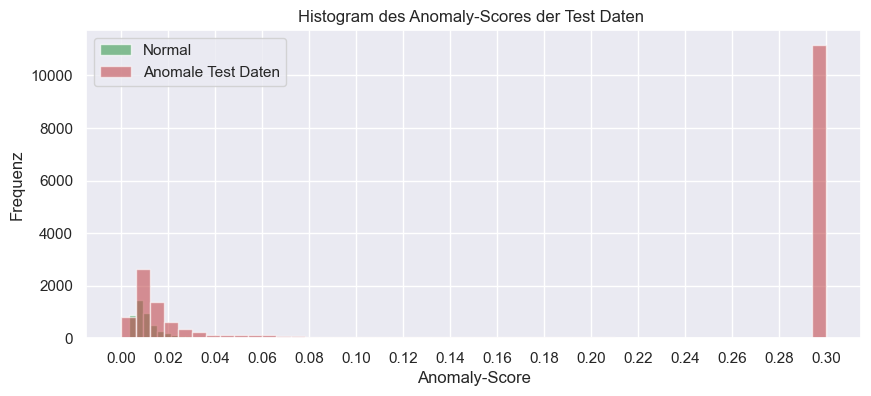

AUCPR: 0.9676198172291797


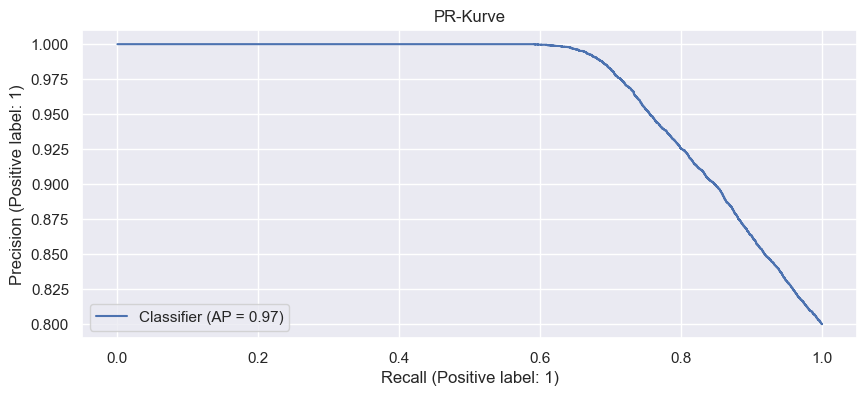

In [68]:
plot_range=[0.00, 0.3]
plt.rcParams['figure.figsize'] = [10, 4]
density=False
colors=["r","b", "m", "y", "c", "black"]

plt.hist(np.mean(mse_normal[:,:],axis=-1),bins = 100,density= density, range=plot_range,color="g",alpha=0.7,log=False, )

for j in range(len(mse_anomlie)):
     mse_mean_over_variablen=np.mean(mse_anomlie[j][:,:],axis=-1)

     for variable in range(len(mse_mean_over_variablen)):
          if mse_mean_over_variablen[variable] > plot_range[-1]:
               mse_mean_over_variablen[variable] = plot_range[-1]

     plt.hist(mse_mean_over_variablen,bins = 50,density= density, range=plot_range,alpha=0.6,log=False, color=colors[j])



plt.legend( ['Normal', 'Anomale Test Daten'])
plt.locator_params(axis='x', nbins=20)
plt.ylabel("Frequenz")
plt.xlabel("Anomaly-Score")
plt.title("Histogram des Anomaly-Scores der Test Daten ")
plt.show()
mse_normal_mean=np.mean(mse_normal[:,:], axis=-1)

mse_anomal_sum=np.array(np.mean(mse_anomlie[0][:,:], axis=-1))
for j in range(1,len(mse_anomlie)):
     mse_anomal_sum=np.append(mse_anomal_sum, np.mean(mse_anomlie[j][:,:], axis=-1), axis=-1)

label_n = np.zeros(len(mse_normal_mean))
label_a = np.ones(len(mse_anomal_sum))
y_score=np.append(mse_normal_mean,mse_anomal_sum)
y_test=np.append(label_n,label_a)


precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_test, y_score)
auc_precision_recall = sklearn.metrics.auc(recall, precision)
print("AUCPR:",auc_precision_recall)
sklearn.metrics.PrecisionRecallDisplay.from_predictions(y_test, y_score)
#plt.xlabel("Precsision TP/(TP+FP)")
#plt.ylabel("Recall TP/(TP+FN)")    
plt.title("PR-Kurve")
plt.show()


In [69]:
normal_score = np.mean(mse_normal[:,:],axis=-1)
anormal_score =  np.append(np.mean(mse_anomlie[0][:,:],axis=-1), 1)

scores = np.append( normal_score, anormal_score)
label = np.append( np.zeros(len(normal_score)) ,np.ones(len(anormal_score)) )


In [70]:
mean_score=scores
thresholds_for_f1=np.arange(0,0.1,0.0001)
anomalie_pred_fro_each_threshold=[]
anomalie_pred_fro_each_threshold= [[0 if (mse<threshold) else 1 for mse in mean_score] for threshold in thresholds_for_f1]

f1_scores=[]
for anomalies_for_each_treshold in anomalie_pred_fro_each_threshold: 
    f1_scores+=[sklearn.metrics.f1_score(label, anomalies_for_each_treshold)]


    #print("\n")

print("threshold",thresholds_for_f1[np.argmax(f1_scores)])
print("best f1", max(f1_scores))

threshold 0.0038
best f1 0.8890951706852939


In [31]:
list_of_thresholds = []

for i in range(np.array(mse_normal).shape[-1]):

    list_of_thresholds+=[np.max(mse_normal[:,i])]


# Define thresholds for each variable

In [32]:
np.float64(list_of_thresholds)

array([0.73294371, 0.72737104, 0.67787516, 1.25085056])

In [33]:
list_of_thresholds[0] = list_of_thresholds[0] * 1.2
list_of_thresholds[1] = list_of_thresholds[1] * 1.5
list_of_thresholds[2] = list_of_thresholds[2] * 1.5

In [34]:
np.float64(list_of_thresholds)

array([0.87953246, 1.09105656, 1.01681274, 1.25085056])

In [35]:
import json

if True:

    model.save("Model")
    
    data=0
    file = open("config.json", "r")
    data = json.load(file)
    file.close()

    new_data={
        "thresholds": dict(zip(range(len(list_of_thresholds)), np.float64(list_of_thresholds) )) ,
        "ground_truth_name_list": dict(zip(range(len(ground_truth_name_list)), ground_truth_name_list)),
        "sliding_window_stride_deployment": 8
    }    
    
    data.update(new_data)

    with open("config.json", "w") as file:  
        json.dump(data, file, indent=2)
        file.close()       


INFO:tensorflow:Assets written to: Model\assets


INFO:tensorflow:Assets written to: Model\assets
